In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from ast import literal_eval
import re

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB,GaussianNB,BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score

In [4]:
# load the data

In [4]:
xcf_flavordb_tb=pd.read_csv('~/final_flavour/june_datasets/(14.09)xcf_tb_flavordb.csv',index_col=0,converters={'flavordb_ingrs':eval})
ars_flavordb_tb=pd.read_csv('~/final_flavour/june_datasets/(23.09)ars_tb_flavordb.csv',index_col=0,converters={'flavordb_ingr':eval})
kb_flavordb_tb=pd.read_csv('~/final_flavour/june_datasets/(09.07)kb_tb_flavordb.csv',index_col=0,converters={'flavordb_ingr':eval})

In [5]:
xcf_flavordb_tb.rename(columns={'flavordb_ingrs':'flavordb_ingr'},inplace=True)

In [6]:
xcf_flavordb_tb=xcf_flavordb_tb.explode('flavordb_ingr')
ars_flavordb_tb=ars_flavordb_tb.explode('flavordb_ingr')
kb_flavordb_tb=kb_flavordb_tb.explode('flavordb_ingr')

In [7]:
xcf_flavordb_tb.reset_index(drop=True,inplace=True)
ars_flavordb_tb.reset_index(drop=True,inplace=True)
kb_flavordb_tb.reset_index(drop=True,inplace=True)

In [8]:
print(xcf_flavordb_tb.shape)
print(ars_flavordb_tb.shape)
print(kb_flavordb_tb.shape)

(12302, 3)
(17287, 3)
(18065, 3)


In [9]:
kb_flavordb_tb.head()

,class,recipe_id,flavordb_ingr
0,0,731,asparagus
1,0,731,butter
2,0,731,capsicum
3,0,731,chive
4,0,731,cooking_oil


In [11]:
# load processed flavor compounds

In [13]:
comp_info=pd.read_csv('~/final_flavour/flavordb_datasets/processed_ingr_comp.csv',index_col=0)
comp_info.shape

(60263, 5)

In [14]:
comp_info.head()

,ingredient_id,ingredient_name,compound_id,compound_name,processed_name
0,0,egg,182,Dimethyl disulfide,dimethyl_disulfide
1,0,egg,1095,L-histidine,histidine
2,0,egg,127,Styrene,styrene
3,0,egg,510,1-Undecanol,undecanol
4,0,egg,549,4-Methylthiazole,methylthiazole


In [15]:
comp_info=pd.DataFrame(comp_info.groupby('ingredient_name')['processed_name'].apply(list)).reset_index()
comp_info.shape

(936, 2)

In [16]:
comp_info.head()

,ingredient_name,processed_name
0,abalone,"[daidzein, geranyl_acetate, nsc, citral, luteo..."
1,abiyuch,"[succinic_acid, farnesal, hexen_one, methyl_he..."
2,acerola,"[lactic_acid, vanillin, betaine, luteolin, cou..."
3,achilleas,[eucalyptol]
4,acorn,"[mannitol, kaempferol, daidzin, daidzein, meth..."


In [15]:
# merge the data with recipe datasets

In [17]:
xcf_comp_tb=pd.merge(xcf_flavordb_tb,comp_info,left_on='flavordb_ingr',right_on='ingredient_name',how='inner')
xcf_comp_tb.shape

(12302, 5)

In [18]:
xcf_comp_tb.head()

,recipe_id,flavordb_ingr,class,ingredient_name,processed_name
0,100000175,rice,1,rice,"[cyclopentanone, daidzin, phenol, butanone, he..."
1,100001692,rice,0,rice,"[cyclopentanone, daidzin, phenol, butanone, he..."
2,100023741,rice,1,rice,"[cyclopentanone, daidzin, phenol, butanone, he..."
3,100026339,rice,0,rice,"[cyclopentanone, daidzin, phenol, butanone, he..."
4,100035610,rice,0,rice,"[cyclopentanone, daidzin, phenol, butanone, he..."


In [19]:
ars_comp_tb=pd.merge(ars_flavordb_tb,comp_info,left_on='flavordb_ingr',right_on='ingredient_name',how='inner')
ars_comp_tb.shape

(17287, 5)

In [20]:
kb_comp_tb=pd.merge(kb_flavordb_tb,comp_info,left_on='flavordb_ingr',right_on='ingredient_name',how='inner')
kb_comp_tb.shape

(18065, 5)

In [28]:
xcf_tb_comp_list=pd.DataFrame(xcf_comp_tb.groupby(['class','recipe_id'])['processed_name'].apply(sum)).reset_index()
ars_tb_comp_list=pd.DataFrame(ars_comp_tb.groupby(['class','recipe_id'])['processed_name'].apply(sum)).reset_index()
kb_tb_comp_list=pd.DataFrame(kb_comp_tb.groupby(['class','recipe_id'])['processed_name'].apply(sum)).reset_index()

In [31]:
xcf_tb_comp_list['processed_name']=xcf_tb_comp_list['processed_name'].apply(lambda x:set(x))
ars_tb_comp_list['processed_name']=ars_tb_comp_list['processed_name'].apply(lambda x:set(x))
kb_tb_comp_list['processed_name']=kb_tb_comp_list['processed_name'].apply(lambda x:set(x))

In [32]:
xcf_tb_comp_list.head()

,class,recipe_id,processed_name
0,0,11478,"{dipentene, lanatoside, methyl_dodecanoate, no..."
1,0,11963,"{methyl_furoate, isopentyl_isobutyrate, methyl..."
2,0,13771,"{violet_leaf_aldehyde, dimethyl_sulfide, hepta..."
3,0,13811,"{benzaldehyde, dihydroxybenzaldehyde, coumaric..."
4,0,17935,"{dipentene, dihydroxybenzaldehyde, dl_liquirit..."


In [33]:
xcf_tb_comp_list['processed_name']=xcf_tb_comp_list['processed_name'].apply(lambda x:sorted(x))
ars_tb_comp_list['processed_name']=ars_tb_comp_list['processed_name'].apply(lambda x:sorted(x))
kb_tb_comp_list['processed_name']=kb_tb_comp_list['processed_name'].apply(lambda x:sorted(x))

In [34]:
kb_tb_comp_list.head()

,class,recipe_id,processed_name
0,0,731,"[103-95-7, 104-50-7, 1195-32-0, 13679-85-1, 22..."
1,0,964,"[13679-85-1, 50-69-1, 87-91-2, acetoin, aceton..."
2,0,1182,"[104-50-7, 13679-85-1, 23726-92-3, 50-69-1, ac..."
3,0,1603,"[1195-32-0, 227456-27-1, 33368-82-0, 483-77-2,..."
4,0,1680,"[104-50-7, 1195-32-0, 13679-85-1, 23726-92-3, ..."


In [35]:
from gensim.models import Word2Vec

In [38]:
def tt_w2v_transformer(data,col1,col2):
    
    # split train test datasets
    train_df,test_df,train_y,test_y=train_test_split(data[col1],data[col2],test_size=0.3,random_state=929)
    train_df=pd.DataFrame(train_df)
    test_df=pd.DataFrame(test_df)
    
    # build the train corpus
    train_corpus=train_df[col1].values.tolist()
    
    # train word2vec 
    num_features=100     
    min_word_count=1  
    num_workers=1
    downsampling = 1e-3

    model=Word2Vec(train_corpus,workers=num_workers,
               vector_size=num_features,min_count=min_word_count,sg=0,sample = downsampling)
    return model,train_df,test_df,train_y,test_y

In [39]:
def get_w2v_features(sentence,model):
        #model_vocabs=set(model.wv.vocab.keys())
        model_vocabs=set(model.wv.key_to_index.keys())
        featureVec = np.zeros(model.vector_size, dtype="float32")

        nwords=0
        for word in sentence:
            if word in model_vocabs:
                #featureVec=np.add(featureVec,model[word])
                featureVec=np.add(featureVec,model.wv[word])
                nwords+=1
            else:
                featureVec=featureVec
        if nwords > 0:
            #print(nwords)
            featureVec=np.divide(featureVec,nwords)
        return featureVec

In [40]:
xcf_model,xcf_train_df,xcf_test_df,xcf_train_y,xcf_test_y=tt_w2v_transformer(xcf_tb_comp_list,'processed_name','class')

In [41]:
xcf_train_df['w2v_features']=list(map(lambda sentence:get_w2v_features(sentence,xcf_model),xcf_train_df['processed_name']))
xcf_test_df['w2v_features']=list(map(lambda sentence:get_w2v_features(sentence,xcf_model),xcf_test_df['processed_name']))

In [42]:
xcf_train_X=np.array(list(map(np.array,xcf_train_df['w2v_features'])))
xcf_test_X=np.array(list(map(np.array,xcf_test_df['w2v_features'])))

In [43]:
ars_model,ars_train_df,ars_test_df,ars_train_y,ars_test_y=tt_w2v_transformer(ars_tb_comp_list,'processed_name','class')

In [44]:
ars_train_df['w2v_features']=list(map(lambda sentence:get_w2v_features(sentence,ars_model),ars_train_df['processed_name']))
ars_test_df['w2v_features']=list(map(lambda sentence:get_w2v_features(sentence,ars_model),ars_test_df['processed_name']))

In [45]:
ars_train_X=np.array(list(map(np.array,ars_train_df['w2v_features'])))
ars_test_X=np.array(list(map(np.array,ars_test_df['w2v_features'])))

In [46]:
kb_model,kb_train_df,kb_test_df,kb_train_y,kb_test_y=tt_w2v_transformer(kb_tb_comp_list,'processed_name','class')

In [47]:
kb_train_df['w2v_features']=list(map(lambda sentence:get_w2v_features(sentence,kb_model),kb_train_df['processed_name']))
kb_test_df['w2v_features']=list(map(lambda sentence:get_w2v_features(sentence,kb_model),kb_test_df['processed_name']))

In [48]:
kb_train_X=np.array(list(map(np.array,kb_train_df['w2v_features'])))
kb_test_X=np.array(list(map(np.array,kb_test_df['w2v_features'])))

In [35]:
# save the w2v features

In [51]:
xcf_train_w2v=pd.concat([xcf_train_df,xcf_train_y],axis=1)
xcf_test_w2v=pd.concat([xcf_test_df,xcf_test_y],axis=1)

In [52]:
ars_train_w2v=pd.concat([ars_train_df,ars_train_y],axis=1)
ars_test_w2v=pd.concat([ars_test_df,ars_test_y],axis=1)

In [53]:
kb_train_w2v=pd.concat([kb_train_df,kb_train_y],axis=1)
kb_test_w2v=pd.concat([kb_test_df,kb_test_y],axis=1)

In [39]:
xcf_train_w2v.to_pickle('datasets/xcf_comp_train_w2v.pkl')
xcf_test_w2v.to_pickle('datasets/xcf_comp_test_w2v.pkl')

ars_train_w2v.to_pickle('datasets/ars_comp_train_w2v.pkl')
ars_test_w2v.to_pickle('datasets/ars_comp_test_w2v.pkl')

kb_train_w2v.to_pickle('datasets/kb_comp_train_w2v.pkl')
kb_test_w2v.to_pickle('datasets/kb_comp_test_w2v.pkl')

In [12]:
xcf_train_w2v=pd.read_pickle('datasets/xcf_comp_train_w2v.pkl')
xcf_test_w2v=pd.read_pickle('datasets/xcf_comp_test_w2v.pkl')

ars_train_w2v=pd.read_pickle('datasets/ars_comp_train_w2v.pkl')
ars_test_w2v=pd.read_pickle('datasets/ars_comp_test_w2v.pkl')

kb_train_w2v=pd.read_pickle('datasets/kb_comp_train_w2v.pkl')
kb_test_w2v=pd.read_pickle('datasets/kb_comp_test_w2v.pkl')

In [54]:
xcf_train_X=np.array(list(map(np.array,xcf_train_w2v['w2v_features'])))
xcf_test_X=np.array(list(map(np.array,xcf_test_w2v['w2v_features'])))

In [55]:
ars_train_X=np.array(list(map(np.array,ars_train_w2v['w2v_features'])))
ars_test_X=np.array(list(map(np.array,ars_test_w2v['w2v_features'])))

In [56]:
kb_train_X=np.array(list(map(np.array,kb_train_w2v['w2v_features'])))
kb_test_X=np.array(list(map(np.array,kb_test_w2v['w2v_features'])))

In [57]:
xcf_train_y=xcf_train_w2v['class']
ars_train_y=ars_train_w2v['class']
kb_train_y=kb_train_w2v['class']

In [58]:
xcf_test_y=xcf_test_w2v['class']
ars_test_y=ars_test_w2v['class']
kb_test_y=kb_test_w2v['class']

In [59]:
# NB
def NB_pipeline(train_X,test_X,train_y,test_y):
    nb = GaussianNB()
    cv=ShuffleSplit(n_splits=10,test_size=0.3,random_state=9527)
    nb_cv_results=cross_val_score(nb,train_X,train_y,cv=cv)
    nb.fit(train_X,train_y)
    y_pred=nb.predict(test_X)
    print('Mean Accuracy: %0.2f (+/- %0.2f)' % (nb_cv_results.mean(), nb_cv_results.std() * 2))
    print('Accuracy on test set: %0.2f' % accuracy_score(y_pred,test_y))
    return y_pred

In [60]:
# logistic regression
def log_pipeline(train_X,test_X,train_y,test_y):
    clf=LogisticRegression(random_state=9527)
    param_distribs={'C':[0.1,1,10,100,1000],
                    'solver':['lbfgs','sag']}
    log_search=RandomizedSearchCV(clf,param_distribs,n_iter=50,cv=5,n_jobs=-1)
    log_search.fit(train_X,train_y)
    print('Best parameters:',log_search.best_params_)
    print('Best estimatro:',log_search.best_estimator_)
    print('Best score:',log_search.best_score_)
    log=log_search.best_estimator_
    y_pred=log.predict(test_X)
    print('accuracy score: ',accuracy_score(y_pred,test_y))
    return y_pred

In [61]:
# random forest
def rf_pipeline(train_X,test_X,train_y,test_y):
    clf=RandomForestClassifier(random_state=42)
    param_distribs={'n_estimators':[int(x) for x in np.linspace(start = 300, stop = 500, num = 10)],
                    'max_features':['auto','sqrt','log2'],
                    'max_depth':[5,6,7,8,9,10],
                    'criterion':['gini','entropy']}
    random_search = RandomizedSearchCV(clf,param_distribs,n_iter=50,cv=5,n_jobs=-1)
    random_search.fit(train_X,train_y)
    print('Best parameters:',random_search.best_params_)
    print('Best estimatro:',random_search.best_estimator_)
    print('Best score:',random_search.best_score_)
    rf=random_search.best_estimator_
    rf.fit(train_X,train_y)
    y_pred=rf.predict(test_X)
    print('accuracy score: ',accuracy_score(y_pred,test_y))
    return y_pred

In [62]:
xcf_nby_pred=NB_pipeline(xcf_train_X,xcf_test_X,xcf_train_y,xcf_test_y)

Mean Accuracy: 0.57 (+/- 0.03)
Accuracy on test set: 0.56


In [63]:
xcf_logy_pred=log_pipeline(xcf_train_X,xcf_test_X,xcf_train_y,xcf_test_y)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Best parameters: {'solver': 'lbfgs', 'C': 10}
Best estimatro: LogisticRegression(C=10, random_state=9527)
Best score: 0.5966439777235832
accuracy score:  0.6084507042253521


In [64]:
xcf_rfy_pred=rf_pipeline(xcf_train_X,xcf_test_X,xcf_train_y,xcf_test_y)

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForest

Best parameters: {'n_estimators': 433, 'max_features': 'sqrt', 'max_depth': 9, 'criterion': 'gini'}
Best estimatro: RandomForestClassifier(max_depth=9, n_estimators=433, random_state=42)
Best score: 0.6286444873148183
accuracy score:  0.6309859154929578


In [65]:
ars_nby_pred=NB_pipeline(ars_train_X,ars_test_X,ars_train_y,ars_test_y)

Mean Accuracy: 0.53 (+/- 0.11)
Accuracy on test set: 0.51


In [66]:
ars_logy_pred=log_pipeline(ars_train_X,ars_test_X,ars_train_y,ars_test_y)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Best parameters: {'solver': 'lbfgs', 'C': 10}
Best estimatro: LogisticRegression(C=10, random_state=9527)
Best score: 0.6349531997037103
accuracy score:  0.65


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means 

In [67]:
ars_rfy_pred=rf_pipeline(ars_train_X,ars_test_X,ars_train_y,ars_test_y)

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForest

Best parameters: {'n_estimators': 477, 'max_features': 'auto', 'max_depth': 9, 'criterion': 'entropy'}
Best estimatro: RandomForestClassifier(criterion='entropy', max_depth=9, max_features='auto',
                       n_estimators=477, random_state=42)
Best score: 0.636957644048394
accuracy score:  0.6421875


In [68]:
kb_nby_pred=NB_pipeline(kb_train_X,kb_test_X,kb_train_y,kb_test_y)

Mean Accuracy: 0.52 (+/- 0.03)
Accuracy on test set: 0.48


In [69]:
kb_logy_pred=log_pipeline(kb_train_X,kb_test_X,kb_train_y,kb_test_y)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Best parameters: {'solver': 'lbfgs', 'C': 1000}
Best estimatro: LogisticRegression(C=1000, random_state=9527)
Best score: 0.589708222811671
accuracy score:  0.6107142857142858


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means 

In [70]:
kb_rfy_pred=rf_pipeline(kb_train_X,kb_test_X,kb_train_y,kb_test_y)

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForest

Best parameters: {'n_estimators': 477, 'max_features': 'auto', 'max_depth': 10, 'criterion': 'gini'}
Best estimatro: RandomForestClassifier(max_depth=10, max_features='auto', n_estimators=477,
                       random_state=42)
Best score: 0.5912761567933982
accuracy score:  0.6


In [ ]:
# learning curve

In [72]:
# Learning curve
def plot_cv_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

In [77]:
xcf_rf=RandomForestClassifier(max_depth=9, n_estimators=433, random_state=42)
ars_rf=RandomForestClassifier(criterion='entropy', max_depth=9, max_features='auto',
                       n_estimators=477, random_state=42)
kb_log=LogisticRegression(C=1000, random_state=9527)

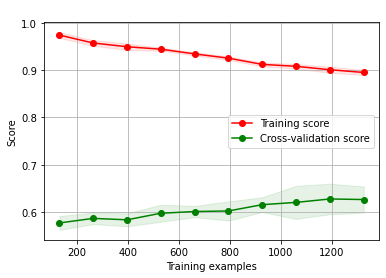

In [74]:
plot_cv_learning_curve(xcf_rf, ' ', xcf_train_X, xcf_train_y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10))
#plt.savefig('fig/pdf/(comp)xcf_tb_w2v_lc.pdf',dpi=300,bbox_inches='tight')
#plt.savefig('fig/png/(comp)xcf_tb_w2v_lc.png',dpi=300,bbox_inches='tight')

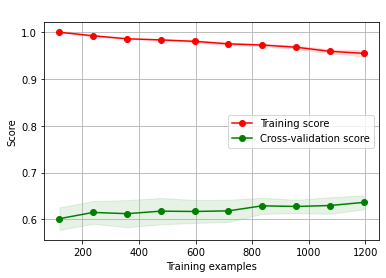

In [78]:
plot_cv_learning_curve(ars_rf, ' ', ars_train_X, ars_train_y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10))
#plt.savefig('fig/pdf/(comp)ars_tb_w2v_lc.pdf',dpi=300,bbox_inches='tight')
#plt.savefig('fig/png/(comp)ars_tb_w2v_lc.png',dpi=300,bbox_inches='tight')

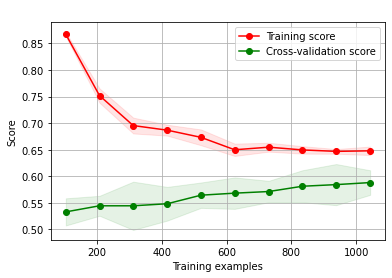

In [76]:
plot_cv_learning_curve(kb_log, ' ', kb_train_X, kb_train_y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10))
#plt.savefig('fig/pdf/(comp)kb_tb_w2v_lc.pdf',dpi=300,bbox_inches='tight')
#plt.savefig('fig/png/(comp)kb_tb_w2v_lc.png',dpi=300,bbox_inches='tight')

In [ ]:
# import roc_auc score to see which classifier performe (slightly better)